**Copyright 2018 The TensorFlow Authors**.

Licensed under the Apache License, Version 2.0 (the "License").

# Generating Handwritten Digits with DCGAN

<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

This tutorial demonstrates how to generate images of handwritten digits using a Deep Convolutional Generative Adversarial Network ([DCGAN](https://arxiv.org/pdf/1511.06434.pdf)). The code is written in [tf.keras](https://www.tensorflow.org/programmers_guide/keras) with [eager execution](https://www.tensorflow.org/programmers_guide/eager) enabled. 

In [28]:
# Install imgeio in order to generate an animated gif showing the image generating process
# !pip install imageio

### Import TensorFlow and enable eager execution

In [29]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

### Load the dataset

We are going to use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [54]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

print(train_images.shape,train_labels.shape)
print(np.ndarray.max(train_images[0]),np.ndarray.min(train_images[0]))
print(train_labels[0:20])

(60000, 28, 28) (60000,)
255 0
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


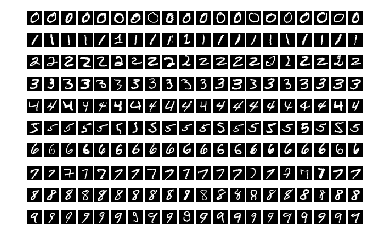

In [31]:
row,col = 10,20

for i in range(row):
    j,k = 0,0
    while (k<col):
        if train_labels[j]==i:
            plt.subplot(row, col, col*i+k+1)
            plt.imshow(train_images[j], cmap="gray")
            plt.axis('off')
            k += 1
        j += 1

plt.savefig("./report/images/dataset_preview.png", bbox_inches = 'tight', pad_inches=0)

In [32]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [33]:
BUFFER_SIZE = len(train_labels)
BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
# BATCH_SIZE = 32

### Use tf.data to create batches and shuffle the dataset

In [61]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

xxx=0
for image in train_dataset:
    xxx+=1
    if xxx==1:
        print(image.shape)
print(xxx,xxx*255)

(256, 28, 28)
235 59925


## Create the models

We will use tf.keras [Sequential API](https://www.tensorflow.org/guide/keras#sequential_model) to define the generator and discriminator models.

### The Generator Model

The generator is responsible for creating convincing images that are good enough to fool the discriminator. The network architecture for the generator consists of [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (Upsampling) layers. We start with a fully connected layer and upsample the image two times in order to reach the desired image size of 28x28x1. We increase the width and height, and reduce the depth as we move through the layers in the network. We use [Leaky ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer except for the last one where we use a tanh activation.

In [35]:
LABEL_SIZE = 0
GEN_LAYER_SIZE = [100+LABEL_SIZE, 128, 64, 1]

def make_generator_model():
    model = tf.keras.Sequential()
    
    GEN_LAYER_IDX = 0
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(GEN_LAYER_SIZE[GEN_LAYER_IDX],)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    GEN_LAYER_IDX += 1
    model.add(tf.keras.layers.Conv2DTranspose(GEN_LAYER_SIZE[GEN_LAYER_IDX], (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, GEN_LAYER_SIZE[GEN_LAYER_IDX])  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    GEN_LAYER_IDX += 1
    model.add(tf.keras.layers.Conv2DTranspose(GEN_LAYER_SIZE[GEN_LAYER_IDX], (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, GEN_LAYER_SIZE[GEN_LAYER_IDX])    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    GEN_LAYER_IDX += 1
    model.add(tf.keras.layers.Conv2DTranspose(GEN_LAYER_SIZE[GEN_LAYER_IDX], (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, GEN_LAYER_SIZE[GEN_LAYER_IDX])
  
    return model

generator = make_generator_model()

### The Discriminator model

The discriminator is responsible for distinguishing fake images from real images. It's similar to a regular CNN-based image classifier.

In [36]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    DIS_LAYER_IDX = -2
    model.add(tf.keras.layers.Conv2D(GEN_LAYER_SIZE[DIS_LAYER_IDX], (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    DIS_LAYER_IDX -= 1
    model.add(tf.keras.layers.Conv2D(GEN_LAYER_SIZE[DIS_LAYER_IDX], (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
       
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(1))
     
    return model
discriminator = make_discriminator_model()

## Define the loss functions and the optimizer

Let's define the loss functions and the optimizers for the generator and the discriminator.


### Generator loss
The generator loss is a sigmoid cross entropy loss of the generated images and an array of ones, since the generator is trying to generate fake images that resemble the real images.

In [37]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

### Discriminator loss

The discriminator loss function takes two inputs: real images, and generated images. Here is how to calculate the discriminator loss:
1. Calculate real_loss which is a sigmoid cross entropy loss of the real images and an array of ones (since these are the real images).
2. Calculate generated_loss which is a sigmoid cross entropy loss of the generated images and an array of zeros (since these are the fake images).
3. Calculate the total_loss as the sum of real_loss and generated_loss.

In [38]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

The discriminator and the generator optimizers are different since we will train two networks separately.

In [39]:
learn_rate = 1e-4
generator_optimizer = tf.train.AdamOptimizer(learn_rate)
discriminator_optimizer = tf.train.AdamOptimizer(learn_rate)

## Set up GANs for Training



Now it's time to put together the generator and discriminator to set up the Generative Adversarial Networks, as you see in the diagam at the beginning of the tutorial.

**Define training parameters**

In [46]:
EPOCHS = 5
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate, GEN_LAYER_SIZE[0]])
# random_vector_for_generation

**Define training method**

We start by iterating over the dataset. The generator is given a random vector as an input which is processed to  output an image looking like a handwritten digit. The discriminator is then shown the real MNIST images as well as the generated images.

Next, we calculate the generator and the discriminator loss. Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables.

In [41]:
def train_step(images):
   # generating noise from a normal distribution
    noise = tf.random_normal([BATCH_SIZE, GEN_LAYER_SIZE[0]])
      
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))


This model takes about ~30 seconds per epoch to train on a single Tesla K80 on Colab, as of October 2018. 

Eager execution can be slower than executing the equivalent graph as it can't benefit from whole-program optimizations on the graph, and also incurs overheads of interpreting Python code. By using [tf.contrib.eager.defun](https://www.tensorflow.org/api_docs/python/tf/contrib/eager/defun) to create graph functions, we get a ~20 secs/epoch performance boost (from ~50 secs/epoch down to ~30 secs/epoch). This way we get the best of both eager execution (easier for debugging) and graph mode (better performance).

In [42]:
train_step = tf.contrib.eager.defun(train_step)

In [43]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        start = time.time()
    
        for images in dataset:
            train_step(images)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, random_vector_for_generation)

        print ('Epoch {} costs {} seconds.'.format(epoch + 1, time.time()-start))
        # generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, random_vector_for_generation)

**Generate and save images**



In [47]:
epoch_images_path = 'epoch_images/'
def generate_and_save_images(generator, epoch, test_input):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    predictions = generator(test_input, training=False)

#     fig = plt.figure(figsize=(4,4))
    fig=plt.figure()
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    if not os.path.exists(epoch_images_path):
        os.mkdir(epoch_images_path)
    
    plt.savefig(epoch_images_path+'epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the GANs
We will call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, you can see the generated digits look increasingly real. After 50 epochs, they look very much like the MNIST digits.

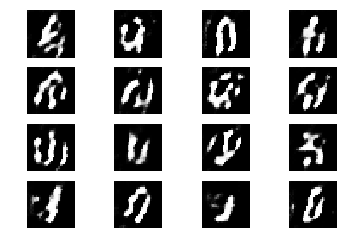

Wall time: 2min 2s


In [48]:
%%time
train(train_dataset, EPOCHS)